In [43]:
# Load Data
from load_data import load_dataset
import pandas as pd

# fp = "/Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-meter-ids.csv"
fp = "/Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned-largest-meter-id.csv"

df = load_dataset(fp, type="pandas", sep=",")

df = df[["meter_id", "timeslot", "type"]]

load_dataset - Filepath: /Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned-largest-meter-id.csv
Loaded dataset to Pandas DataFrame


In [76]:
df_prod = df[df["type"] == "production"]
df_prod.reset_index(drop=True, inplace=True)

In [60]:
# Get index for timeslot = 01-01-2018 00:01:00

def create_ideal_index(index_start, index_end):
    new_index = []
    # Find hours between index_start and index_end
    hours = (pd.to_datetime(index_end) - pd.to_datetime(index_start)).total_seconds() // 3600
    # Create list of hourly datetime index_start to datetime index_end
    for i in range(0, int(hours)):
        new_index.append(
            pd.to_datetime(
                index_start) + pd.Timedelta(i, unit="h")
        )
    # Convert new_index to string
    new_index = [str(x).replace("02:00", "02") for x in new_index]
    return new_index



In [13]:
import numpy as np
import matplotlib.pyplot as plt
def plot_missing_dates_on_timeline(start, end, missing, title = "Missing timeslots"):
    """Plot missing dates on timeline

    Args:
        min (datetime): start date on timeline
        max (datetime): end date on timeline
        missing (list): list of missing dates in the interval
        title (str, optional): Plot title. Defaults to "Missing timeslots".
    """
    
    # Plot missing timeslot values 
    # Inspired by https://matplotlib.org/3.5.1/gallery/lines_bars_and_markers/timeline.html

    # Choose some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                    int(np.ceil(len(missing)/6)))[:len(missing)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title=title)

    ax.vlines(missing, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(missing, np.zeros_like(missing), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # Set x-axis interval
    ax.set_xlim(start, end)

    ax.margins(y=0.1)
    plt.show()

In [47]:
# Get unique meter_ids
meter_ids_unique = df.meter_id.unique()
print(len(meter_ids_unique))

1


In [69]:
# Loop through meter_ids and calculate yearly coverage
full_coverage_meter_ids = []

df_loop = df

df_coverages = pd.DataFrame(columns=["meter_id", "year_coverage"])

for idx, meter_id in enumerate(meter_ids_unique):
    dat = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)

    # Get first and last timeslot
    first_timeslot = dat[0]
    last_timeslot = dat[-1]
    new_index = create_ideal_index(first_timeslot, last_timeslot)

    print(dat[0], dat[-1])

    overlap = list(set(dat) & set(new_index))
    missing = list(set(new_index) - set(dat))
    # print(len(overlap), len(missing))
    
    # plot_missing_dates_on_timeline(pd.to_datetime(first_timeslot), pd.to_datetime(last_timeslot), pd.to_datetime(missing))
    
    # Calculate coverage
    coverage = len(overlap) / len(new_index)
    print("Meter_id: ", meter_id, " Coverage: ", coverage, ", ", idx, " out of ", len(meter_ids_unique))
    df_coverages.loc[idx] = [meter_id, coverage]


23591.0
2016-09-04 00:00:00+02 2019-05-14 23:00:00+02
Meter_id:  28ba7f57-6e83-4341-8078-232c1639e4e3  Coverage:  0.5215548302318681 ,  0  out of  1


In [67]:
# Print unique timeslots
print(len(df_prod["timeslot"].unique()))

23568


In [49]:
df_coverages = df_coverages.sort_values(by="year_coverage", ascending=False)
print(df_coverages.head())

                               meter_id  year_coverage
0  28ba7f57-6e83-4341-8078-232c1639e4e3       0.572374


In [35]:
# Save to csv
df_coverages.to_csv("year_coverage.csv", index=False)

In [50]:
# Find 10 meter_ids with highest coverage
df_coverages_10 = df_coverages.head(10)

28ba7f57-6e83-4341-8078-232c1639e4e3
23591.0
2017-12-16 13:00:00+02


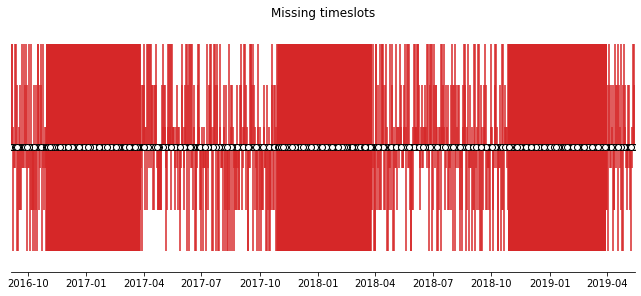

In [72]:
for meter_id in df_coverages_10["meter_id"]:
    print(meter_id)
    dat = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)
    first_timeslot = dat[0]
    last_timeslot = dat[-1]
    new_index = create_ideal_index(first_timeslot, last_timeslot)
    overlap = list(set(dat) & set(new_index))
    missing = list(set(new_index) - set(dat))
    print(missing[0])
    plot_missing_dates_on_timeline(pd.to_datetime(first_timeslot), pd.to_datetime(last_timeslot), pd.to_datetime(missing))

In [79]:
# Find 2017-12-16 13:00:00+02 in timeslot
# print(df_prod[df_prod["timeslot"] == "2017-12-16 13:00:00+02"])
print(df_prod["timeslot"].iloc[0])
print(type(df_prod["timeslot"].iloc[0]))

2017-09-04 05:00:00+02
<class 'str'>
